
# Sentiment analysis in movie reviews

Implement a simple neural network to classify movie reviews (predict and label the movie reviews as "positive" or "negative").

Import the necessary libraries and print the version of TensorFlow API:

In [ ]:
!pip install Keras-Preprocessing

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
import numpy as np

print(tf.__version__)

2.12.0


## Import the IMDB dataset

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) which contains the text of 50,000 movie reviews. We will use 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets contain an equal number of positive and negative reviews (i.e., they are *balanced*).

For illustration, a piece of a negative review with 2 stars is as follows:

>>> *"Now, I LOVE Italian horror films. The cheesier they are, the better. However, this is not cheesy Italian. This is week-old spaghetti sauce with rotting meatballs. It is amateur hour on every level. There is no suspense, no horror, with just a few drops of blood scattered around to remind you that you are in fact watching a horror film."*
<table>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://www.imdb.com/review/rw1795788/">Sample review</a> (for the movie "Don't Look in the Attic").<br/>&nbsp;
  </td></tr>
</table>

Import and load the data from TensorFow (the data is already split into test and training sets, and words are converted to integers):


In [ ]:

 (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=12000,index_from=3)

Note the argument `num_words=10000` keeps the top 10,000 most frequently occurring words to keep the size of the data manageable.

## Explore the data

Explore the format of the **training** and **testing** datasets (25,000 reviews with each review is represented as an array of integers):

In [ ]:
print(train_data.shape)
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))
print(test_data.shape)
print("Testing entries: {}, labels: {}".format(len(test_data), len(test_labels)))

(25000,)
Training entries: 25000, labels: 25000
(25000,)
Testing entries: 25000, labels: 25000


Explore the labels of the **training** dataset (each label is either 0 (negative) or 1 (positive)):

In [ ]:
train_labels

array([1, 0, 0, ..., 0, 1, 0])

Display the 1st review in the **training** dataset (reviews are converted to integers and each integer represents a specific word):

In [ ]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Display the number of words in the first five reviews (needs processing, because inputs to a neural network must be the same length):

In [ ]:
for i in range(0,5):
  print(len(train_data[i]))

218
189
141
550
147


If you want to look at the 1st review in words ...

In [ ]:
# A dictionary mapping words to an integer index
word_to_id = imdb.get_word_index()
# The first indices are reserved
word_to_id = {k:(v+3) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2  # unknown
word_to_id["<UNUSED>"] = 3
id_to_word = {value:key for key,value in word_to_id.items()}

You can get the index of word and convert training data to word format:

In [ ]:
print(' '.join(id_to_word[id] for id in train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be prais

## Prepare the data

Standardize the length of movie reviews by using the [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) function:

In [ ]:
train_data = pad_sequences(train_data,
                           value=word_to_id["<PAD>"],
                           padding='post',
                           maxlen=256)

test_data = pad_sequences(test_data,
                          value=word_to_id["<PAD>"],
                          padding='post',
                          maxlen=256)

Note the argument `value=word_to_id["<PAD>"]` indicates that sequences that are shorter than `num_timesteps` are padded with value 0 at the end.

`num_timesteps` is either the `maxlen` argument if provided, or the length of the longest sequence otherwise.

Display the number of words in the first five reviews to confirm the padding:

In [ ]:
for i in range(0,5):
  print(len(train_data[i]))

256
256
256
256
256


Inspect the (now padded) 1st review:

In [ ]:
print(train_data[0])

[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670     2     9    35   480   284     5   150     4   172   112
   167     2   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18     2     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4     2     7  3766
     5   723    36    71    43   530   476    26   400   317    46     7
     4     2  1029    13   104    88     4   381   

In [ ]:
print(' '.join(id_to_word[id] for id in train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be prais

In [ ]:
arr = np.array(train_data[0])
arr = arr[arr != 0]

# Get unique elements and their counts
unique_elements, counts = np.unique(arr, return_counts=True)

# Find the index of the highest count
index_most_frequent = np.argmax(counts)

# Extract the most frequent value and its count
most_frequent_value = unique_elements[index_most_frequent]
count_most_frequent = counts[index_most_frequent]

print("Most frequent value:", most_frequent_value)
print("Count of the most frequent value:", count_most_frequent)
print("The word for the most frequent code:", id_to_word[most_frequent_value])


Most frequent value: 4
Count of the most frequent value: 15
The word for the most frequent code: the


In [ ]:
from collections import Counter

# Assuming train_data[0] is a list of word IDs
word_ids = train_data[0]

# Convert word IDs to words using the id_to_word dictionary, excluding <PAD>
words = [id_to_word[id] for id in word_ids if id_to_word[id] != '<PAD>']

# Use Counter to count the occurrences of each word
word_counts = Counter(words)

# Find the most common word
most_common_word = word_counts.most_common(1)[0][0]

print("The most common word (excluding <PAD>) is:", most_common_word)


The most common word (excluding <PAD>) is: the


In [ ]:
from collections import Counter

# Assuming train_data[0] is a list of word IDs
word_ids = train_data[0]

# Convert word IDs to words using the id_to_word dictionary, excluding <PAD>
words = [id_to_word[id] for id in word_ids if id_to_word[id] != '<PAD>']

# Use Counter to count the occurrences of each word
word_counts = Counter(words)

# Find the most common word and its frequency
most_common_word, frequency = word_counts.most_common(1)[0]

# Find the corresponding integer value for the most common word
most_common_word_id = word_to_id[most_common_word]

print("The most common word is:", most_common_word)
print("The corresponding integer value is:", most_common_word_id)
print("The frequency of the most common word is:", frequency)


The most common word is: the
The corresponding integer value is: 4
The frequency of the most common word is: 15


## Bag of Words (Vectorization)
We use bag of words to convert a document to a vector. It counts the number of word occurence on a review.

In [ ]:
unique_words = set()
for s in train_data:
    unique_words = unique_words.union(set(s))
for s in test_data:
    unique_words = unique_words.union(set(s))

In [ ]:
len(unique_words)

11999

In [ ]:
def bag_of_words(doc):
    num_of_words = dict.fromkeys(unique_words, 0)
    for word in doc:
        num_of_words[word] += 1
    return np.fromiter(num_of_words.values(), dtype=int)

In [ ]:
x_train = np.array([bag_of_words(i) for i in train_data])
x_test = np.array([bag_of_words(i) for i in test_data])

## Create a validation set

Create a *validation set* by setting apart 5,000 examples from the training data. (the validation set will be used to tune our model).

In [ ]:
partial_x_train = x_train[:20000]
x_val = x_train[20000:]

partial_y_train = train_labels[:20000]
y_val = train_labels[20000:]

In [ ]:
partial_x_train.shape

(20000, 11999)

In [ ]:
# each input is a sparse vector size of 9999
partial_x_train[0]

array([38,  1,  5, ...,  0,  0,  0])

## Build the model

The neural network is created by stacking layers—this requires two main architectural decisions:

* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of an array of word representation. The labels to predict are either 0 or 1. Let's build a model for this problem:

In [ ]:
model = Sequential()
# this layer is a 64-unit (or neuron) ReLU layer, it's the first learning layer
model.add(Dense(64,input_shape = (partial_x_train.shape[1],)))
model.add(Activation('relu'))
# this layer is a 32-unit (or neuron) ReLU layer, it's the second learning layer
model.add(Dense(32))
model.add(Activation('relu'))
# this layer is a single-unit (or neuron) Sigmoid layer, it outputs the predicted label
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768000    
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
 activation_2 (Activation)   (None, 1)                 0         
                                                                 
Total params: 770,113
Trainable params: 770,113
Non-trai

![Activation Function](1_XxxiA0jJvPrHEJHD4z893g.png)


### Compile the model

Define the loss function, optimizer, and performance metric using the model's *compile* step:

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

## Train the model

Train the model for 10 epochs with batch size of 256:

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
313/313 [==============================] - 11s 30ms/step - loss: 0.3609 - accuracy: 0.8340 - val_loss: 0.3077 - val_accuracy: 0.8684
Epoch 2/10
313/313 [==============================] - 9s 28ms/step - loss: 0.1757 - accuracy: 0.9322 - val_loss: 0.3018 - val_accuracy: 0.8770
Epoch 3/10
313/313 [==============================] - 8s 27ms/step - loss: 0.0934 - accuracy: 0.9675 - val_loss: 0.4326 - val_accuracy: 0.8518
Epoch 4/10
313/313 [==============================] - 10s 30ms/step - loss: 0.0546 - accuracy: 0.9820 - val_loss: 0.5067 - val_accuracy: 0.8594
Epoch 5/10
313/313 [==============================] - 7s 21ms/step - loss: 0.0285 - accuracy: 0.9905 - val_loss: 0.5350 - val_accuracy: 0.8760
Epoch 6/10
313/313 [==============================] - 11s 35ms/step - loss: 0.0124 - accuracy: 0.9969 - val_loss: 0.6538 - val_accuracy: 0.8726
Epoch 7/10
313/313 [==============================] - 7s 23ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.7312 - val_accuracy: 0.8

## Evaluate the model

Evaluate the accuracy of the model by making predictions using the model in the test dataset:

In [ ]:
test_loss, test_acc = model.evaluate(x_test, test_labels)

print('Test accuracy:', test_acc)

782/782 [==============================] - 6s 8ms/step - loss: 0.7465 - accuracy: 0.8432
Test accuracy: 0.8431599736213684


## Plot the accuracy and loss of the model

Plot both the accuracy and loss over time (as the number of epochs increase):

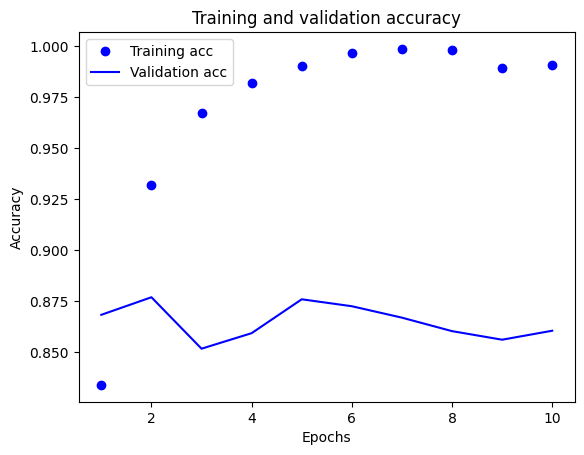

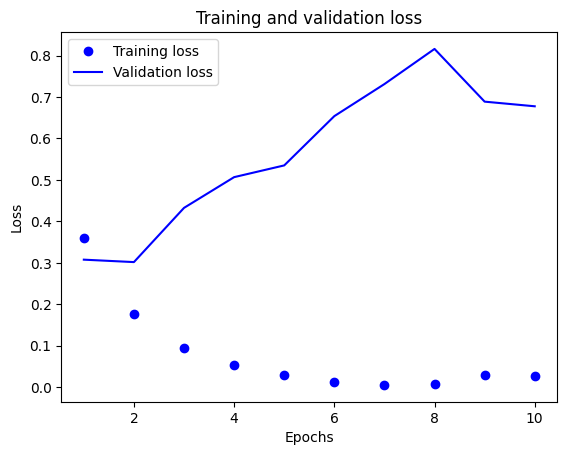

In [ ]:
history_dict = history.history
history_dict.keys()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.clf()   # clear figure
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Copyright 2018 The TensorFlow Authors

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.